In [1]:
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import scipy.integrate
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, triu, spdiags
from scipy.sparse.linalg import spsolve, splu
import scipy.sparse
import scipy.optimize
from numpy.linalg import inv

import time

### Number 1

In [2]:
#initialize for n = 128
L = 10
n = 128 
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
dx = x[1]-x[0]

#time
Time = 2
t = np.linspace(0, Time, 501)
dt = t[1] - t[0]
time_steps = int(Time/dt)

CFL = (2*dt)/(dx**2)

### Number 4 (A3) - Correct

In [3]:
def matrix_FE(n):
    e1 = np.ones(n)
    A = scipy.sparse.spdiags([-e1, -e1,16*e1,-30*e1,16*e1,-e1, -e1], [-n+2,-2,-1,0,1,2,n-2],n,n, format = 'csc')
    A[0,n-1] = 16
    A[n-1,0] = 16
    
    A = A/12
    
    return A 

In [4]:
A3 = matrix_FE(128).todense()

/Users/annahuang/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Number 6 (A5) - Correct

In [5]:
#Forward Euler 
def FE(A, n, CFL, t):
    L = 10
    x2 = np.linspace(-L, L, n+1)
    x = x2[0:n]
    
    Time = 2
    t = np.linspace(0, Time, t)
    dt = t[1] - t[0]
    time_steps = int(Time/dt)
    
    # print(f"length of x: {len(x)}")
    # print(f"length of t: {len(t)}")
    # print(f"time steps: {time_steps}")
    
    usol_fe = np.zeros((len(x), len(t)))
    u0 = (10*np.cos((2*np.pi*x)/L) + 30*np.cos((8*np.pi*x)/L)).T
    usol_fe[:,0] = u0
    u1 = u0 
    
    for j in range(time_steps):
        u2 = u1 + CFL*A@u1
        u1 = u2
        usol_fe[:,j+1] = u2
    
    return usol_fe

In [6]:
A5 = FE(matrix_FE(128), 128, CFL, 501)[:,-1].reshape(128,1)

### Number 8 (A7 & A8) - Correct

In [7]:
def matrix_PLU(n, CFL):
    e1 = np.ones(n)
    
    M = scipy.sparse.spdiags([e1,-2*e1,e1], [-1,0,1],n,n, format = 'csc')
    
    M[0,n-1] = 1
    M[n-1,0] = 1
    
    B = (scipy.sparse.eye(n, format = 'csc') - ((CFL/2)*M))
    C = (scipy.sparse.eye(n, format = 'csc') + ((CFL/2)*M))
    
    return B, C

In [8]:
B = matrix_PLU(128, CFL)[0]
C = matrix_PLU(128, CFL)[1]

In [9]:
A7 = B.todense()
A8 = C.todense()

### Number 9 (A9) - Correct

In [10]:
def PLU(B, C, n, t):
    L = 10
    Time = 2
    x2 = np.linspace(-L, L, n+1)
    x = x2[0:n]
    
    Time = 2
    t = np.linspace(0, Time, t)
    dt = t[1] - t[0]
    time_steps = int(Time/dt)

    PLU = scipy.sparse.linalg.splu(B)
    
    usol_plu = np.zeros((len(x),len(t))) #placeholder for solution - more effcient
    u0 = ((10*np.cos((2*np.pi*x)/L) + 30*np.cos((8*np.pi*x)/L)).T)
    usol_plu[:,0] = C@u0

    start = time.time()
    for j in range(time_steps):
        u1 = PLU.solve(C@u0)
        u0 = u1 
        usol_plu[:,j+1] = u1

    end = time.time()
    # print(end-start)
    
    return usol_plu

In [11]:
A9 = PLU(B, C, 128, 501)[:,-1].reshape(128,1)

### Number 11 (A11 & A12) - Correct

In [12]:
exact_128 = np.genfromtxt("exact_128.csv", delimiter=',')

In [13]:
A11 = np.linalg.norm(exact_128-A5.reshape(128))

In [14]:
A12 = np.linalg.norm(exact_128-A9.reshape(128))

### Number 12 (A13 & A14) - Incorrect

In [15]:
exact_256 = np.genfromtxt("exact_256.csv", delimiter=',')

In [16]:
A13 = np.linalg.norm(exact_256-FE(matrix_FE(256), 256, CFL, 2001)[:,-1].reshape(256))

In [17]:
B256 = matrix_PLU(256, CFL)[0]
C256 = matrix_PLU(256, CFL)[1]

In [18]:
A14 = np.linalg.norm(exact_256-PLU(B256,C256, 256, 2001)[:,-1].reshape(256))

### 512

In [19]:
#For 512 points, it is 8001
#For 1024 points, it is 32001 

In [20]:
exact_512 = np.genfromtxt("exact_512.csv", delimiter=',')

In [21]:
A15 = np.linalg.norm(exact_512-FE(matrix_FE(512), 512, CFL, 8001)[:,-1].reshape(512))

In [22]:
B512 = matrix_PLU(512, CFL)[0]
C512 = matrix_PLU(512, CFL)[1]

In [23]:
A16 = np.linalg.norm(exact_512-PLU(B512,C512, 512, 8001)[:,-1].reshape(512))

### 1024

In [24]:
exact_1024 = np.genfromtxt("exact_1024.csv", delimiter=',')

In [25]:
A17 = np.linalg.norm(exact_1024-FE(matrix_FE(1024), 1024, CFL, 32001)[:,-1].reshape(1024))

In [26]:
B1024 = matrix_PLU(1024, CFL)[0]
C1024 = matrix_PLU(1024, CFL)[1]

In [27]:
A18 = np.linalg.norm(exact_1024-PLU(B1024,C1024, 1024, 32001)[:,-1].reshape(1024))

In [28]:
L = 10
n = 256
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
dx_256 = x[1]-x[0]

In [29]:
L = 10
n = 512
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
dx_512 = x[1]-x[0]

In [30]:
L = 10
n = 1024
x2 = np.linspace(-L, L, n+1)
x = x2[0:n]
dx_1024 = x[1]-x[0]

In [31]:
dx_all = np.array([dx, dx_256, dx_512, dx_1024])

In [39]:
dx_all

array([0.15625   , 0.078125  , 0.0390625 , 0.01953125])

In [32]:
FE_all = np.array([A11,A13,A15,A17])

In [33]:
LU_all = np.array([A12,A14,A16,A18])

In [34]:
trendline_FE = np.polyfit(np.log(dx_all), np.log(FE_all), 1)
FE_trend = trendline_FE[0]
print(f"Forward Euler (1,4) Slope: {FE_trend}")

Forward Euler (1,4) Slope: 1.500093276692452


In [35]:
print(f"At n = 128, the error is: {FE_all[0]}")
print(f"At n = 256, the error is: {FE_all[1]}")
print(f"At n = 512, the error is: {FE_all[2]}")
print(f"At n = 1024, the error is: {FE_all[3]}")

At n = 128, the error is: 0.04113471729137664
At n = 256, the error is: 0.01454107045824732
At n = 512, the error is: 0.00514084686368391
At n = 1024, the error is: 0.0018175464225023386


In [36]:
trendline_LU = np.polyfit(np.log(dx_all), np.log(LU_all), 1)
LU_trend = trendline_LU[0]
print(f"Crank-Nicolson (2,2) Slope: {LU_trend}")

Crank-Nicolson (2,2) Slope: 1.4996731740992677


In [37]:
print(f"At n = 128, the error is: {LU_all[0]}")
print(f"At n = 256, the error is: {LU_all[1]}")
print(f"At n = 512, the error is: {LU_all[2]}")
print(f"At n = 1024, the error is: {LU_all[3]}")

At n = 128, the error is: 0.02090281135171564
At n = 256, the error is: 0.00739425697380374
At n = 512, the error is: 0.0026146184479072404
At n = 1024, the error is: 0.000924438612185603


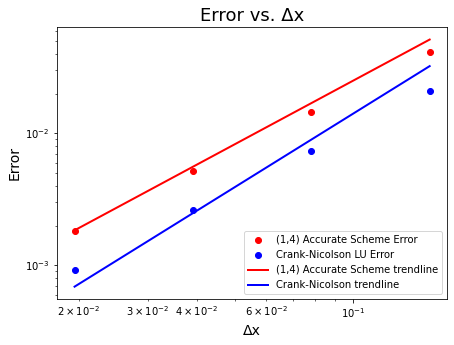

In [40]:
figure = plt.figure(figsize=[7, 5])

plt.loglog(dx_all,FE_all.T, linewidth = 0, marker= 'o', color = 'red', label="(1,4) Accurate Scheme Error")
plt.loglog(dx_all,LU_all.T, linewidth = 0, marker= 'o', color = 'blue', label="Crank-Nicolson LU Error")

plt.loglog(dx_all,dx_all**(FE_trend+.1), color='red', linewidth = 2, label="(1,4) Accurate Scheme trendline")
plt.loglog(dx_all,dx_all**(LU_trend+.35), color='blue', linewidth = 2, label="Crank-Nicolson trendline")

plt.legend(loc="lower right")
plt.title('Error vs. Δx', fontsize=18)
plt.xlabel('Δx', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.show()

figure.savefig("loglog.png")